### Importing Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,regularizers,Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D,Activation, Concatenate,UpSampling2D,Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import classification_report
import os
import random
import json
from tensorflow.keras.utils import plot_model
from functools import partial
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import utils
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping 
from keras.layers import *
import utils
import cv2
from skimage.segmentation import mark_boundaries
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image

%matplotlib inline

tf.keras.backend.clear_session()

### GPU Config

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(physical_devices[0],[tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Loading dataset as .JSON format

In [ ]:
def load_dataset(dataset_folder, shuffle=True, balanced=False):
    X = []
    y = []
    json_files = [el for el in dataset_folder.iterdir() if el.suffix == ".json"]

    if shuffle:
        random.shuffle(json_files)

    for json_file in json_files:
        with open(json_file) as f:
            sample = json.load(f)

        X.append(cv2.imread(sample["image"]))
        y.append([sample["angle"]])

    #one hot encoding angles : left, straight, right steering direction
    one_hot = OneHotEncoder(sparse_output=False)
    y = one_hot.fit_transform(y)  #fitting on training data

    #convert to np arrays & preprocessing images
    
    X = np.asarray(X)
    X = X.astype("float32")
    # Normalize
    X = X / 255.0
    y = np.asarray(y)

    if balanced:
        samples_class = int(min(np.sum(y, axis=0)))
        X_subsampled = []
        y_subsampled = []
        for col in range(y.shape[1]):
            y_direction = y[:, col]
            index = np.where(y_direction == 1)[0]
            X_selected = X[index][:samples_class]
            y_selected = y[index][:samples_class]
            print(X_selected.shape,y_selected.shape)
            X_subsampled.extend(X_selected)
            y_subsampled.extend(y_selected)

        X = np.asarray(X_subsampled)
        y = np.asarray(y_subsampled)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [4]:
current_folder = Path.cwd()
dataset_folder = current_folder / "dataset"
images_folder = dataset_folder / "images"
models_folder = current_folder / "models"
logs_folder = current_folder / "logs"


In [5]:
X_train, X_test, y_train, y_test = load_dataset(dataset_folder)

In [6]:
X_train.shape

(5522, 64, 128, 3)

In [7]:
y_train.shape

(5522, 3)

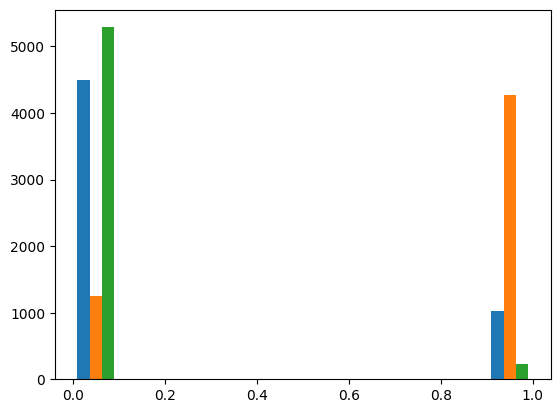

In [8]:
plt.hist(y_train)
plt.show()

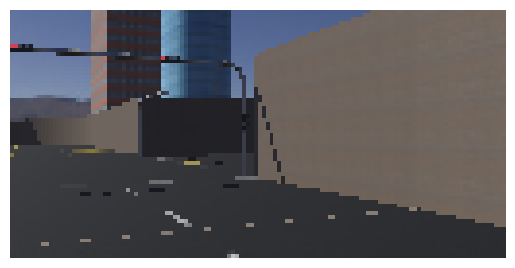

In [9]:
def get_image(index):
    image = X_train[index]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

image_rgb = get_image(1500) 

plt.axis("off")
plt.imshow(image_rgb)

### Model

Squeeze-and-Excitation (SE) Attention

In [ ]:
def attention_module(x, filters):
    
    se = GlobalAveragePooling2D()(x)  # Squeeze: Global Pooling
    se = Dense(filters // 16, activation="relu")(se)  # Reduce dimension
    se = Dense(filters, activation="sigmoid")(se)  # Expand dimension
    se = Multiply()([x, se])  # Excitation: Scale input
    return se

In [ ]:

def residual_block(x, filters, kernel_size=(3, 3), downsample=False):
    """Residual Block with SE Attention"""
    shortcut = x  #saved input for skip connection

    x = Conv2D(filters, kernel_size, activation='swish', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation='swish', padding='same')(x)
    x = BatchNormalization()(x)

    #Applied attention
    x = attention_module(x, filters)

    #Adjusting shortcut dimensions
    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)

    x = Add()([x, shortcut])  # Skip connection
    return x


In [ ]:
def CNNModel(input_shape=(64, 128, 3), num_classes=3):

    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = residual_block(x, filters=64)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, filters=128)
    x = MaxPooling2D((2, 2))(x)

    skip = Conv2D(128, (1, 1), padding='same')(inputs)
    skip = MaxPooling2D((8, 8))(skip)  

    x = Add()([x, skip])  #con+

    x = residual_block(x, filters=256)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model


Create and summarizing the model

In [ ]:
model = CNNModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [14]:
#plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

### loss
- sparse_categorical_crossentropy used for sparse labels (target class index)
- categorial_cross_entropy would yield a one hot vector (only one positive label)
- mean_squared_error for regression

In [15]:
model.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(X_train,y_train,epochs=20,batch_size=4,validation_data=(X_test,y_test))

Epoch 1/20
1381/1381 [==============================] - 47s 23ms/step - loss: 0.6200 - accuracy: 0.7687 - val_loss: 0.5727 - val_accuracy: 0.7735
Epoch 2/20
1381/1381 [==============================] - 27s 20ms/step - loss: 0.5599 - accuracy: 0.7800 - val_loss: 0.5914 - val_accuracy: 0.7729
Epoch 3/20
1381/1381 [==============================] - 27s 19ms/step - loss: 0.5207 - accuracy: 0.7796 - val_loss: 0.6369 - val_accuracy: 0.7702
Epoch 4/20
1381/1381 [==============================] - 27s 20ms/step - loss: 0.4928 - accuracy: 0.7850 - val_loss: 0.5426 - val_accuracy: 0.7833
Epoch 5/20
1381/1381 [==============================] - 28s 20ms/step - loss: 0.4436 - accuracy: 0.7983 - val_loss: 0.4143 - val_accuracy: 0.8273
Epoch 6/20
1381/1381 [==============================] - 27s 20ms/step - loss: 0.4047 - accuracy: 0.8138 - val_loss: 0.4453 - val_accuracy: 0.7936
Epoch 7/20
1381/1381 [==============================] - 28s 20ms/step - loss: 0.3646 - accuracy: 0.8339 - val_loss: 0.3113 -

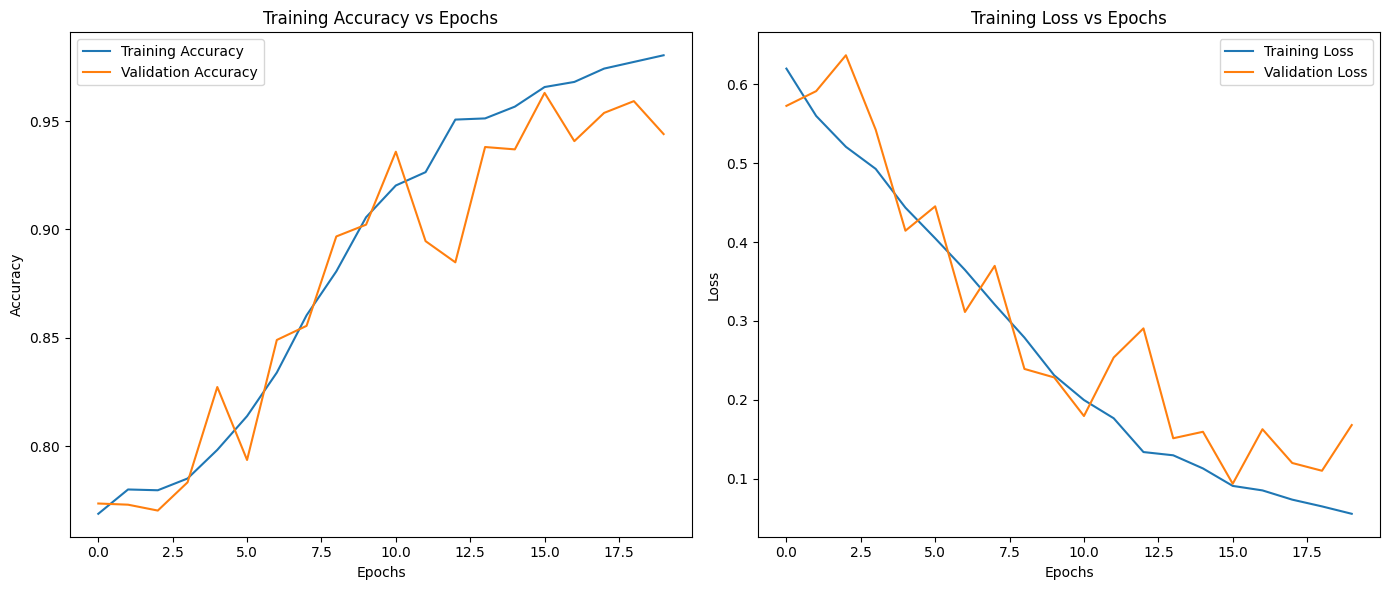

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy'], label='Training Accuracy')

if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')


plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()  
plt.show()

In [18]:
os.makedirs(models_folder,exist_ok=True)
model.save(models_folder / "selfDrivingModelUpdatewithAttention.h5")

In [19]:
model.evaluate(X_test,y_test)

58/58 [==============================] - 2s 23ms/step - loss: 0.1679 - accuracy: 0.9441


[0.16786743700504303, 0.9440521597862244]

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  

58/58 [==============================] - 1s 18ms/step


In [ ]:
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       357
           1       0.99      0.93      0.96      1412
           2       0.62      0.99      0.76        72

   micro avg       0.94      0.94      0.94      1841
   macro avg       0.83      0.96      0.88      1841
weighted avg       0.96      0.94      0.95      1841
 samples avg       0.94      0.94      0.94      1841



c:\Users\tisha\anaconda3\envs\TF\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


current_folder = Path("")
images_folder = current_folder / "dataset" / "images"
models_folder = current_folder / "models"
latest_image_path = utils.get_latest_file_path(images_folder)

model = utils.get_model(models_folder, -1)  # -1 -- latest

for layer in model.layers:
    layer.trainable = False

image = cv2.imread(str(latest_image_path))
image = utils.preprocess_images(image)

#reshape image -> 4 dimensions
image_rs = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

- Left image: pixels used for classification 
- Right image: green increase the probability of being of the true class
- the ones colored in red decrease the proability

In [ ]:
def imageExp(image_id):
    image_path = images_folder / f"image_{image_id}.png"

    image = cv2.imread(str(image_path))
    image = utils.preprocess_images(image)

    

    explainer = lime_image.LimeImageExplainer()

    #if top_labels grater than 1 -> the positive area increases
    explanation = explainer.explain_instance(image.astype("double"), model,
                                             top_labels=1, hide_color=0, num_samples=1000)

    image_rs = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    output = np.array(model(image_rs, training=False))[0]
    if len(output) == 1:
        print(f"Angle {float(angle):.2f}")
    else:
        print(output)

    

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

   

In [ ]:
imageExp(64)

In [ ]:
imageExp(128)

In [ ]:
imageExp(256)

In [ ]:
imageExp(512)

In [ ]:
imageExp(1024)

In [ ]:
imageExp(3000)